,결측치 개수
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


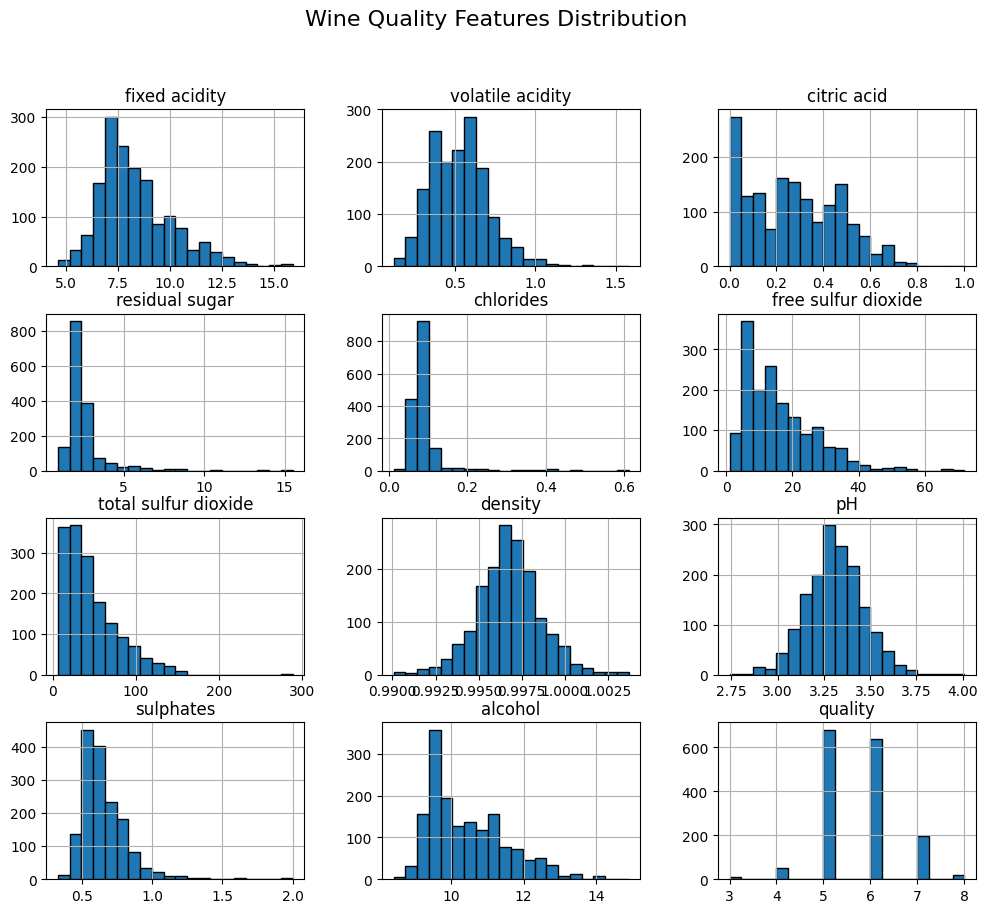

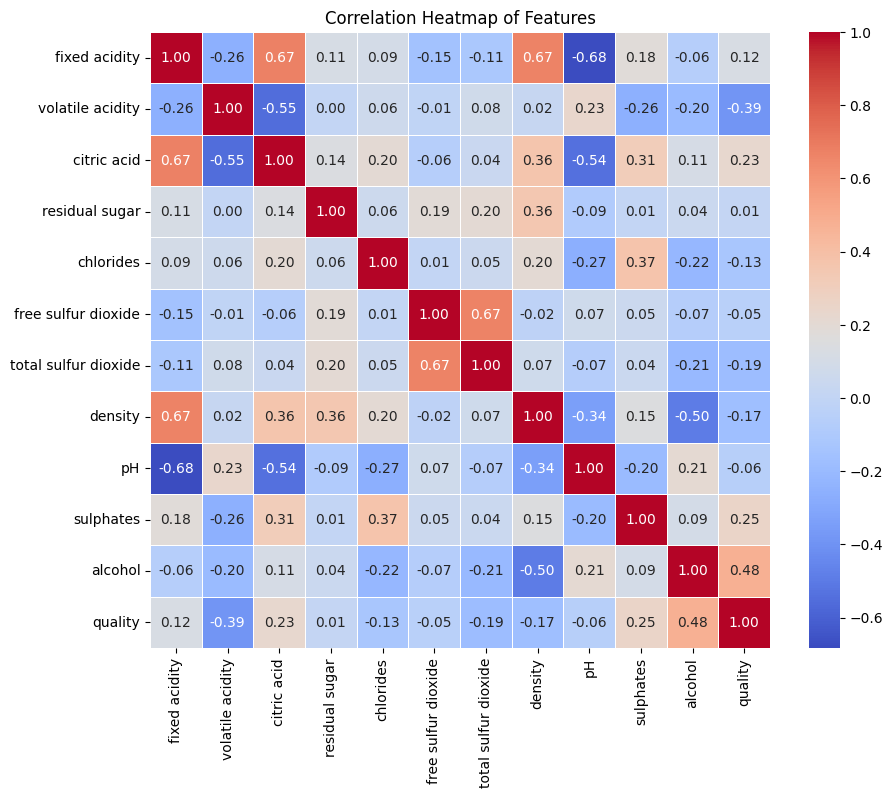

,Variable,Coefficient,P-Value
2,volatile acidity,-1.0836,0.000
5,chlorides,-1.8742,0.000
6,free sulfur dioxide,0.0044,0.045
7,total sulfur dioxide,-0.0033,0.000
9,pH,-0.4137,0.031
10,sulphates,0.9163,0.000
11,alcohol,0.2762,0.000


,Model,RMSE (Root Mean Squared Error),MAE (Mean Absolute Error),R^2 Score (Explained Variance)
0,Linear Regression,0.624520,0.503530,0.403180
1,Random Forest,0.550889,0.425344,0.535614


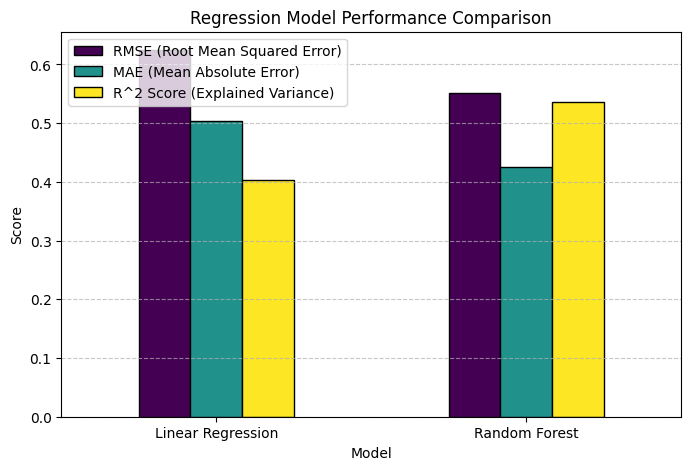

,Metric,Score
0,Accuracy,0.790625
1,Precision,0.811111
2,Recall,0.815642


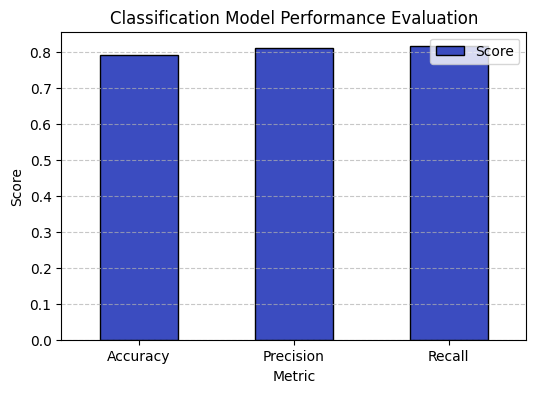

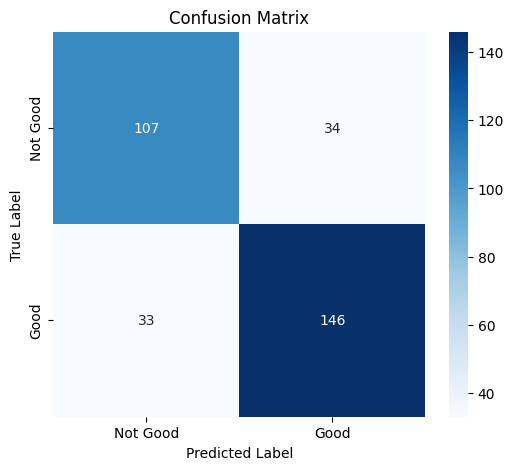

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display
import numpy as np

# 폰트 설정 (영어만 사용)
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use default font for English
plt.rcParams['axes.unicode_minus'] = True  # To properly show negative signs

# 📌 1️⃣ 데이터 불러오기
file_path = "./winequality-red.csv"
df = pd.read_csv(file_path)

# 📌 2️⃣ 결측치 확인 및 출력
missing_values = df.isnull().sum()
missing_df = pd.DataFrame(missing_values, columns=["결측치 개수"])  # Change to Korean
display(missing_df)

# 📌 3️⃣ 각 변수(특징)의 분포를 확인하기 위한 히스토그램 그리기
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Wine Quality Features Distribution", fontsize=16)  # Title in English
plt.show()

# 📌 4️⃣ 상관계수 행렬 시각화 (변수 간의 관계 확인)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")  # Title in English
plt.show()

# 📌 5️⃣ OLS 회귀 분석 (품질에 영향을 주는 중요한 변수 확인)
X = df.drop(columns=['quality'])  # 독립 변수(품질을 제외한 모든 변수)
y = df['quality']  # 종속 변수 (와인 품질 점수)
X = sm.add_constant(X)  # 상수항 추가

model = sm.OLS(y, X).fit()  # OLS 회귀 분석 모델 생성 및 학습

# 📌 회귀 분석 결과를 보기 쉽게 정리 (중요한 변수만 출력)
summary_df = pd.DataFrame(model.summary().tables[1].data[1:], columns=model.summary().tables[1].data[0])
summary_df.columns = ["Variable", "Coefficient", "Std Err", "t-Value", "P-Value", "[0.025", "0.975]"]
summary_df = summary_df.drop(columns=["Std Err", "t-Value", "[0.025", "0.975]"])  # 불필요한 칼럼 제거
summary_df["P-Value"] = summary_df["P-Value"].astype(float)  # 숫자로 변환

# 유의미한 변수만 출력 (P-값이 0.05 미만인 경우)
significant_vars = summary_df[summary_df["P-Value"] < 0.05]
display(significant_vars)

# 📌 6️⃣ 회귀 모델 (선형 회귀 vs 랜덤 포레스트 비교)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습 및 평가
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 랜덤 포레스트 회귀 모델 학습 및 평가
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 회귀 모델 성능 비교
metrics = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE (Root Mean Squared Error)": [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "MAE (Mean Absolute Error)": [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf)],
    "R^2 Score (Explained Variance)": [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)]
})

# 📌 회귀 모델 비교 결과 출력
display(metrics)

# 📊 회귀 모델 성능 시각화
metrics.set_index("Model").plot(kind="bar", figsize=(8, 5), colormap="viridis", edgecolor="black")
plt.title("Regression Model Performance Comparison")  # Title in English
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 📌 7️⃣ 분류 모델 (와인 품질을 '좋음(6점 이상)' / '나쁨(6점 미만)'으로 구분)
y_class = (df["quality"] >= 6).astype(int)  # 품질이 6점 이상이면 1, 미만이면 0
X = df.drop(columns=["quality"])
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_class)
y_pred_class = rf_clf.predict(X_test)

# 분류 모델 평가 지표 계산
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# 📌 분류 모델 평가 결과 출력
classification_results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Score": [accuracy, precision, recall]
})
display(classification_results)

# 📊 분류 모델 성능 시각화
classification_results.set_index("Metric").plot(kind="bar", figsize=(6, 4), colormap="coolwarm", edgecolor="black")
plt.title("Classification Model Performance Evaluation")  # Title in English
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 📌 8️⃣ 혼동 행렬 시각화 (예측과 실제 값 비교)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Good", "Good"], yticklabels=["Not Good", "Good"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")  # Title in English
plt.show()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

,Model,RMSE,MAE,R^2 Score
0,Random Forest (Red Wine),0.548852,0.422438,0.539043
1,Random Forest (White Wine),0.589708,0.418520,0.550978


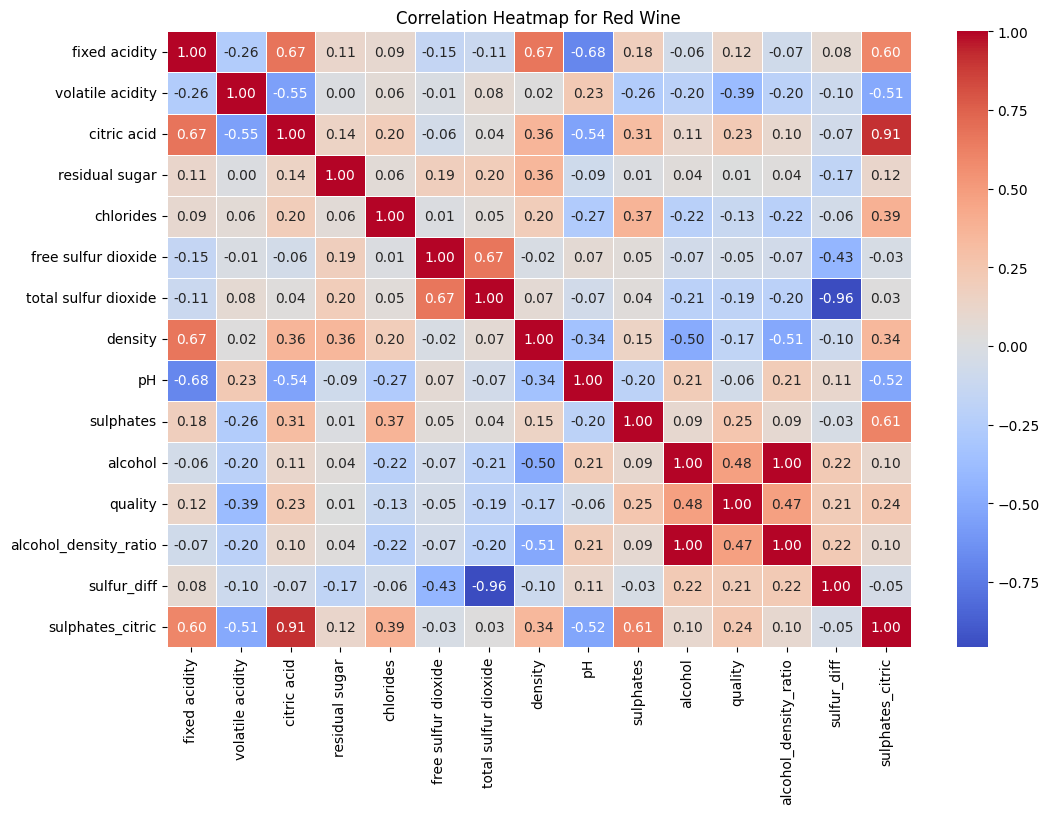

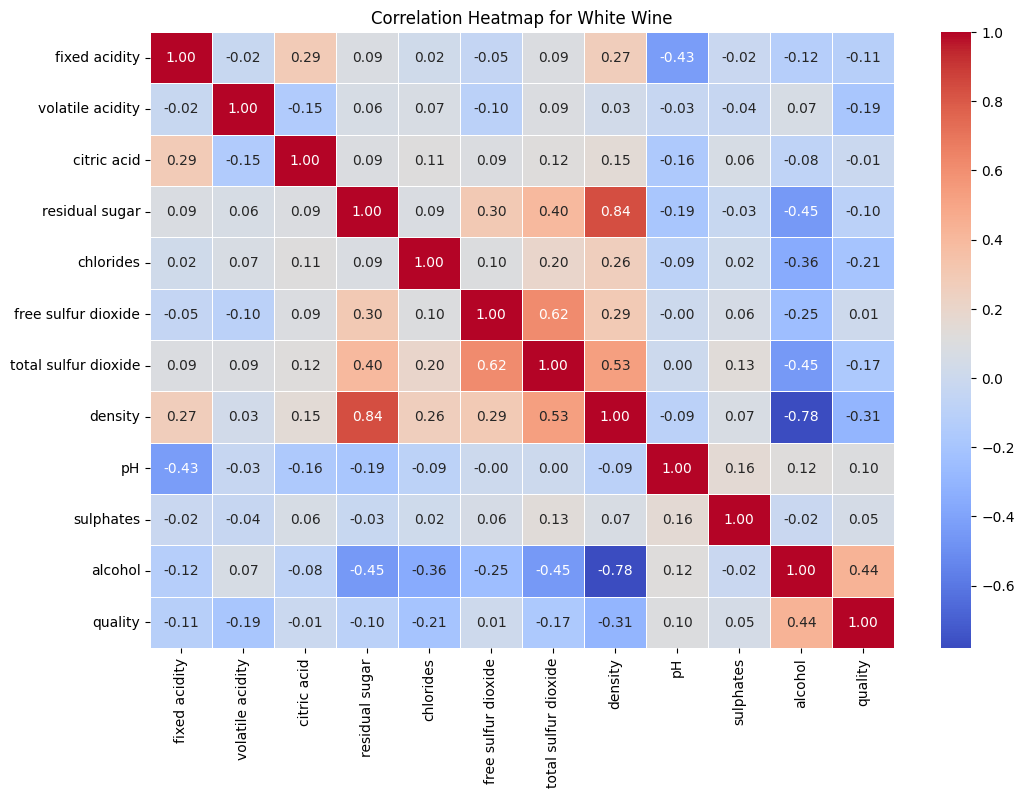

In [25]:
# 화이트 와인 데이터 불러오기
white_df = pd.read_csv("./winequality-white.csv", delimiter=';')

# 컬럼 이름에서 불필요한 공백 제거
white_df.columns = white_df.columns.str.strip()

# 화이트 와인의 일부 데이터 확인
print(white_df.head())

# 3. 모델 성능 비교: 회귀 모델에서 성능 지표 계산
# 화이트 와인 모델 (회귀) 학습
white_X = white_df.drop(columns=['quality'])
white_y = white_df['quality']
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(white_X, white_y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
white_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
white_rf_model.fit(white_X_train, white_y_train)
white_y_pred = white_rf_model.predict(white_X_test)

# 성능 지표 계산 (화이트 와인)
white_metrics = pd.DataFrame({
    "Model": ["Random Forest (White Wine)"],
    "RMSE": [np.sqrt(mean_squared_error(white_y_test, white_y_pred))],
    "MAE": [mean_absolute_error(white_y_test, white_y_pred)],
    "R^2 Score": [r2_score(white_y_test, white_y_pred)]
})

# 4. 레드 와인 모델 성능 비교
# 기존의 레드 와인 모델 (회귀)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
red_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
red_rf_model.fit(X_train, y_train)
y_pred_red = red_rf_model.predict(X_test)

# 성능 지표 계산 (레드 와인)
red_metrics = pd.DataFrame({
    "Model": ["Random Forest (Red Wine)"],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_red))],
    "MAE": [mean_absolute_error(y_test, y_pred_red)],
    "R^2 Score": [r2_score(y_test, y_pred_red)]
})

# 성능 비교
comparison_metrics = pd.concat([red_metrics, white_metrics], ignore_index=True)

# 결과를 출력
display(comparison_metrics)

# 5. 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Red Wine")
plt.show()

# 화이트 와인의 상관관계 히트맵
plt.figure(figsize=(12, 8))
sns.heatmap(white_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for White Wine")
plt.show()